# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.utils import resample
from tqdm import tqdm
import contractions
import random
from textblob import TextBlob
import codecs
from lib_file import lib_path
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=set(stopwords.words('english'))
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

ModuleNotFoundError: No module named 'contractions'

# Data Loading

In [ ]:
df = pd.read_csv('input/cyberbullying_tweets.csv')

***Preliminary Analysis***

In [ ]:
df.head()

In [4]:
df.shape

(39869, 2)

# Data Preprocessing

In [5]:
df.columns=['text','class']
df.head()

,text,class
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [6]:
df.isnull().sum()

text     0
class    0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39869 entries, 0 to 39868
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    39869 non-null  object
 1   class   39869 non-null  object
dtypes: object(2)
memory usage: 623.1+ KB


In [8]:
class_labels = df['class'].unique().tolist()
class_labels.sort()

print(class_labels)

['age', 'ethnicity', 'gender', 'not_cyberbullying', 'religion']


In [9]:
df['class'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: class, dtype: int64

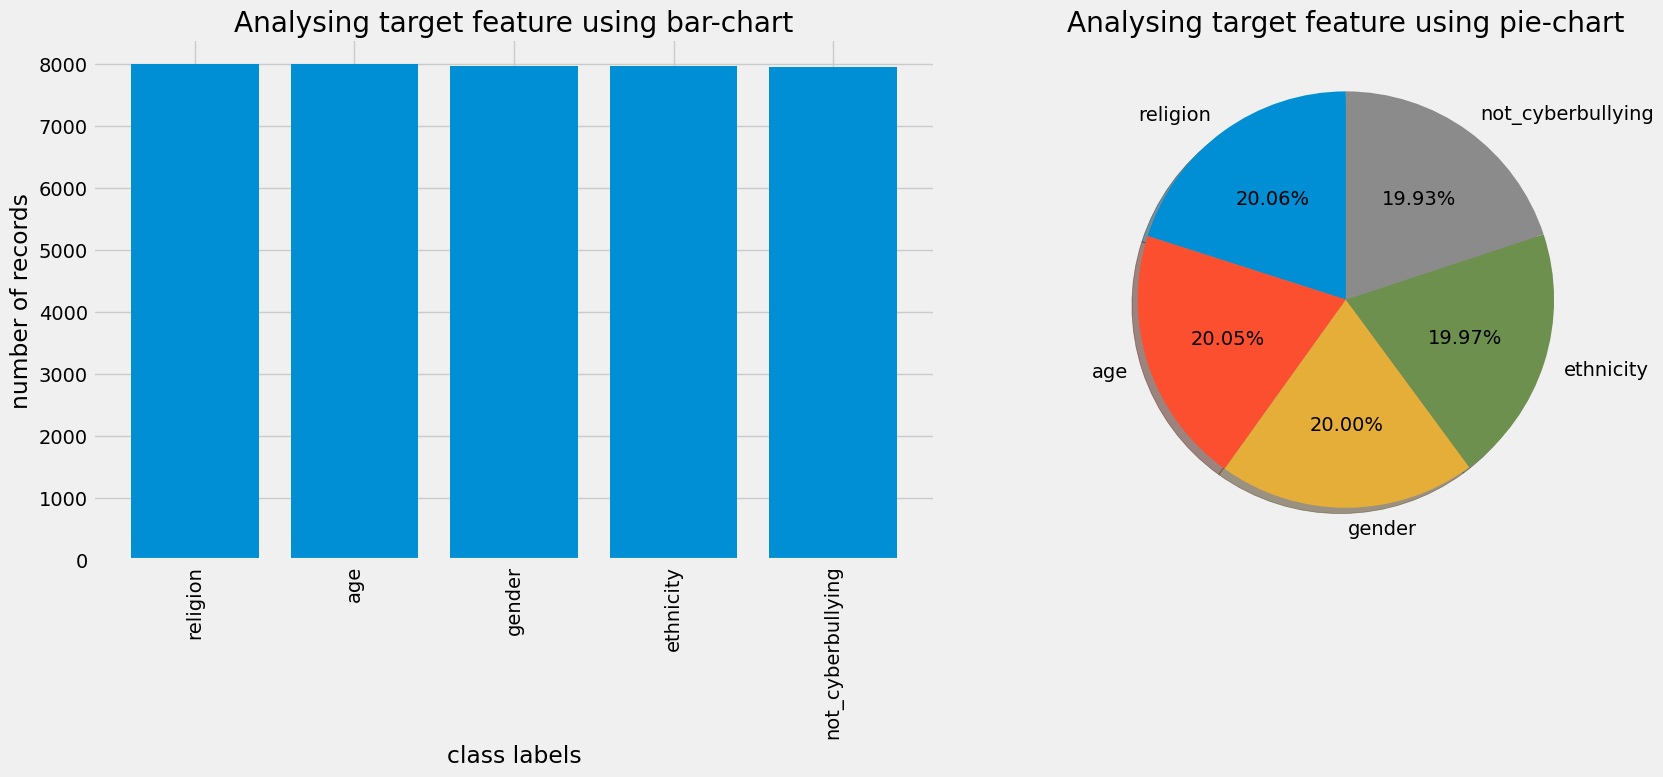

In [10]:
viz_data=dict(df['class'].value_counts())
with plt.style.context(style='fivethirtyeight'):
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(18,8))
    axes[0].bar(x=list(viz_data.keys()),
                height=list(viz_data.values()))
    axes[0].set_title(label='Analysing target feature using bar-chart')
    axes[0].set_xlabel(xlabel='class labels')
    axes[0].set_ylabel(ylabel='number of records')
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)
    axes[1].pie(x=list(viz_data.values()),
                labels=list(viz_data.keys()),
                autopct='%.2f%%',pctdistance=0.60,
                startangle=90,
                shadow=True)
    axes[1].set_title(label='Analysing target feature using pie-chart')
    fig.tight_layout()
    plt.show()

In [11]:
def clean_text(text):
    # expand contraction for words
    text=contractions.fix(text)
    # remove charectir emojes
    emoticons = [r':\)', r':\(', r':P']
    pattern = '|'.join(emoticons)
    text = re.sub(pattern, '', text)
    # remove mentions (@)
    text = re.sub(r'@\w+', '', text)
    # remove hashtags (#)
    text = re.sub(r'#\w+', '', text)
    # remove URLs (http and https)
    text = re.sub(r'https?://\S+', '', text)
    # remove non-alphanumeric characters
    text = re.sub(r'[^\w\s]', '', text)
    # remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Perform lemmatization and stopwords removal on each word in the sentence
    blob = TextBlob(text)
    lemmatized_words = [word.lemmatize() for word in blob.words if word not in stop_words]
    # Join the lemmatized words back into a sentence
    lemmatized_sentence = " ".join(lemmatized_words)
    # convert to lowercase
    text = lemmatized_sentence.lower()
    return text

In [12]:
sentences = []

for sentence in tqdm(df['text'].values.tolist()):
    sentences.append(clean_text(sentence))

100%|███████████████████████████████████████████████████████████████████████████| 39869/39869 [00:41<00:00, 957.02it/s]


In [17]:
df['cleaned_text'] = sentences
df.head()

,text,class,cleaned_text
0,"In other words #katandandre, your food was cra...",not_cyberbullying,in word food crapilicious
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,why white
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore or red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,this isis account pretending kurdish account l...


In [18]:
df['sequence_length'] = df['cleaned_text'].apply(lambda x: len(str(x).split(' ')))
df.head()

,text,class,cleaned_text,sequence_length
0,"In other words #katandandre, your food was cra...",not_cyberbullying,in word food crapilicious,4
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,why white,2
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore or red velvet cupcake,6
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...,8
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,this isis account pretending kurdish account l...,9


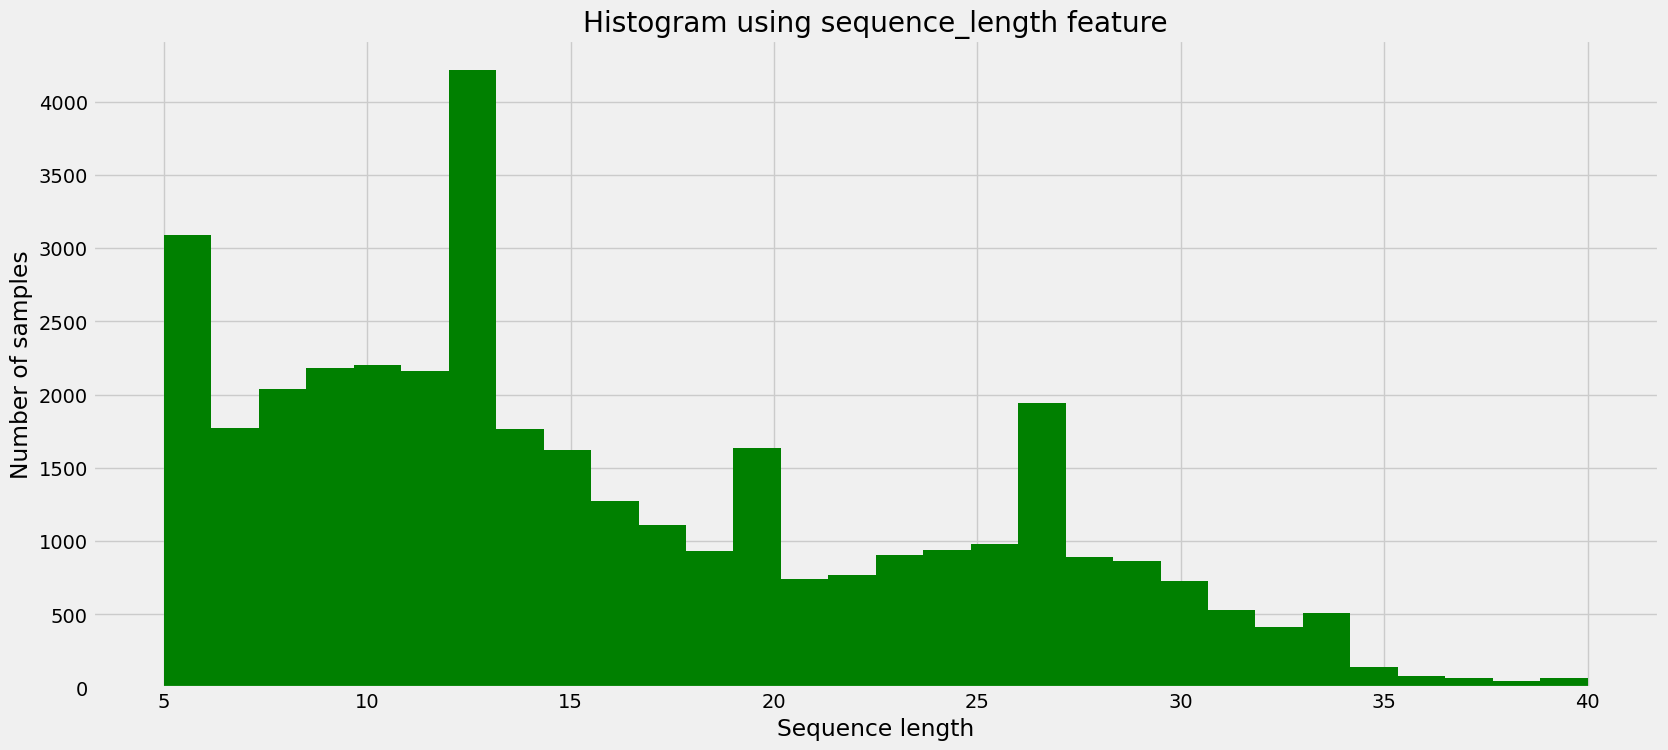

In [19]:
df=df[(df['sequence_length']>=5) & (df['sequence_length']<=40)]
with plt.style.context(style='fivethirtyeight'):
    plt.figure(figsize=(18,8))
    plt.hist(df['sequence_length'].values,color='green',bins=30)
    plt.title(label='Histogram using sequence_length feature')
    plt.xlabel(xlabel='Sequence length')
    plt.ylabel(ylabel='Number of samples')
    plt.show()

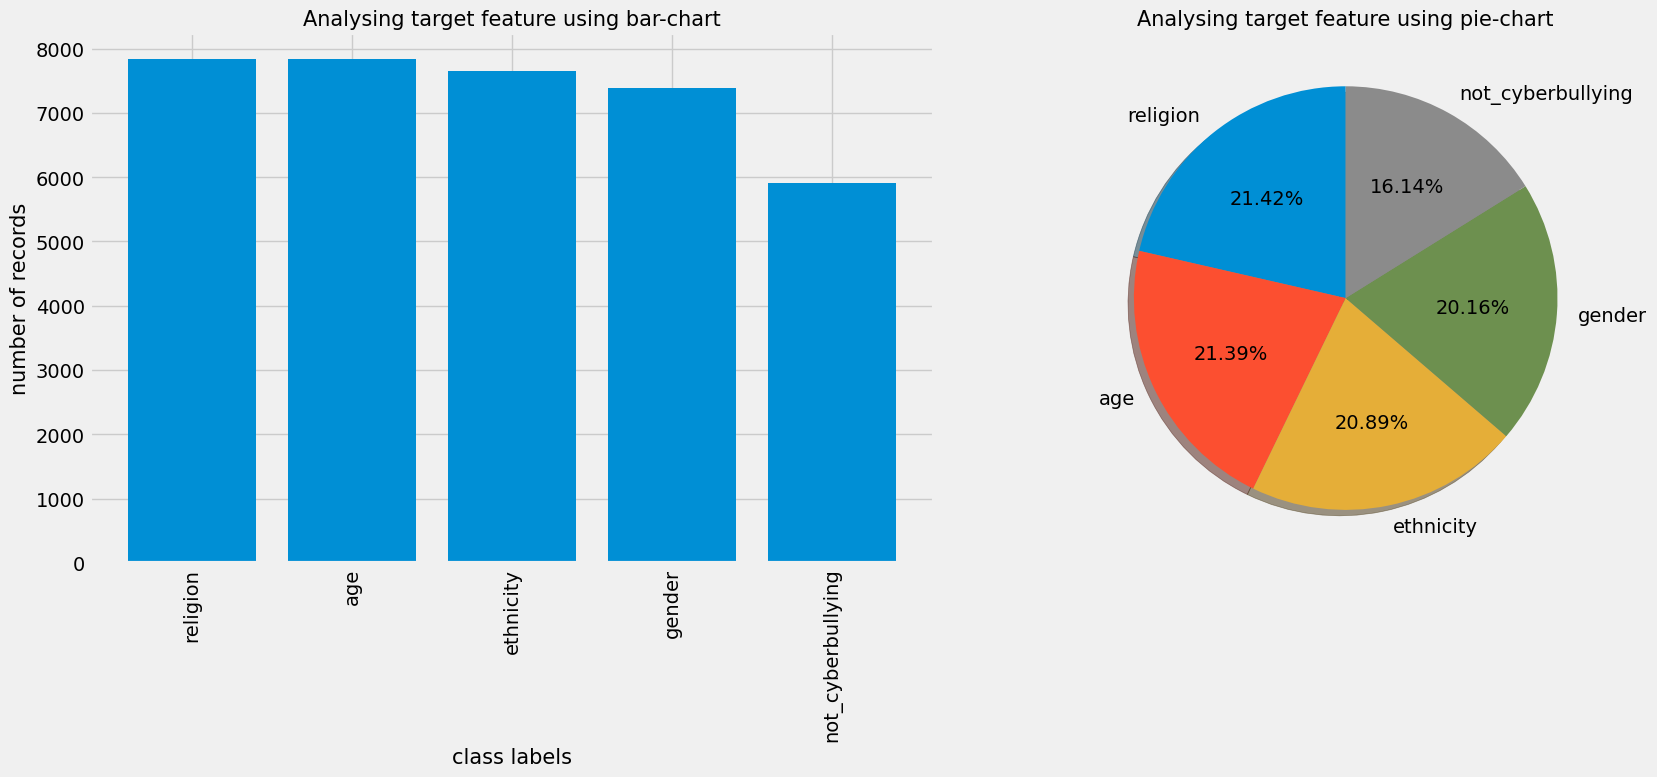

In [20]:
viz_data=dict(df['class'].value_counts())
with plt.style.context(style='fivethirtyeight'):
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(18,8))
    axes[0].bar(x=list(viz_data.keys()),
                height=list(viz_data.values()))
    axes[0].set_title(label='Analysing target feature using bar-chart', fontsize=15)
    axes[0].set_xlabel(xlabel='class labels', fontsize=15)
    axes[0].set_ylabel(ylabel='number of records', fontsize=15)
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)
    axes[1].pie(x=list(viz_data.values()),
                labels=list(viz_data.keys()),
                autopct='%.2f%%',pctdistance=0.60,
                startangle=90,
                shadow=True)
    axes[1].set_title(label='Analysing target feature using pie-chart', fontsize=15)
    fig.tight_layout()
    plt.show()

In [21]:
df = df[['cleaned_text','class']]

In [22]:
df.head()

,cleaned_text,class
2,classy whore or red velvet cupcake,not_cyberbullying
3,meh thanks head concerned another angry dude t...,not_cyberbullying
4,this isis account pretending kurdish account l...,not_cyberbullying
5,yes test god good bad indifferent weird whatev...,not_cyberbullying
6,itu sekolah ya bukan tempat bully ga jauh kaya...,not_cyberbullying


In [23]:
df.shape

(36622, 2)

In [24]:
resampled = []

for label in df['class'].unique().tolist():
    label_df=df.loc[df['class']==label]
    resampled.append(resample(label_df,n_samples=max(df['class'].value_counts())))
data=pd.concat(objs=resampled,ignore_index=True)
data=data.sample(frac=1).reset_index(drop=True)
data.head()

,cleaned_text,class
0,idiot christian need complain america 73 chris...,religion
1,anyone else hear female reporter call kayleigh...,gender
2,stupide nigger fucking nigger better stupid ho...,ethnicity
3,sometimes i hate brisbane tweeting 1hr behind ...,not_cyberbullying
4,catching if society judge two pretty i really ...,gender


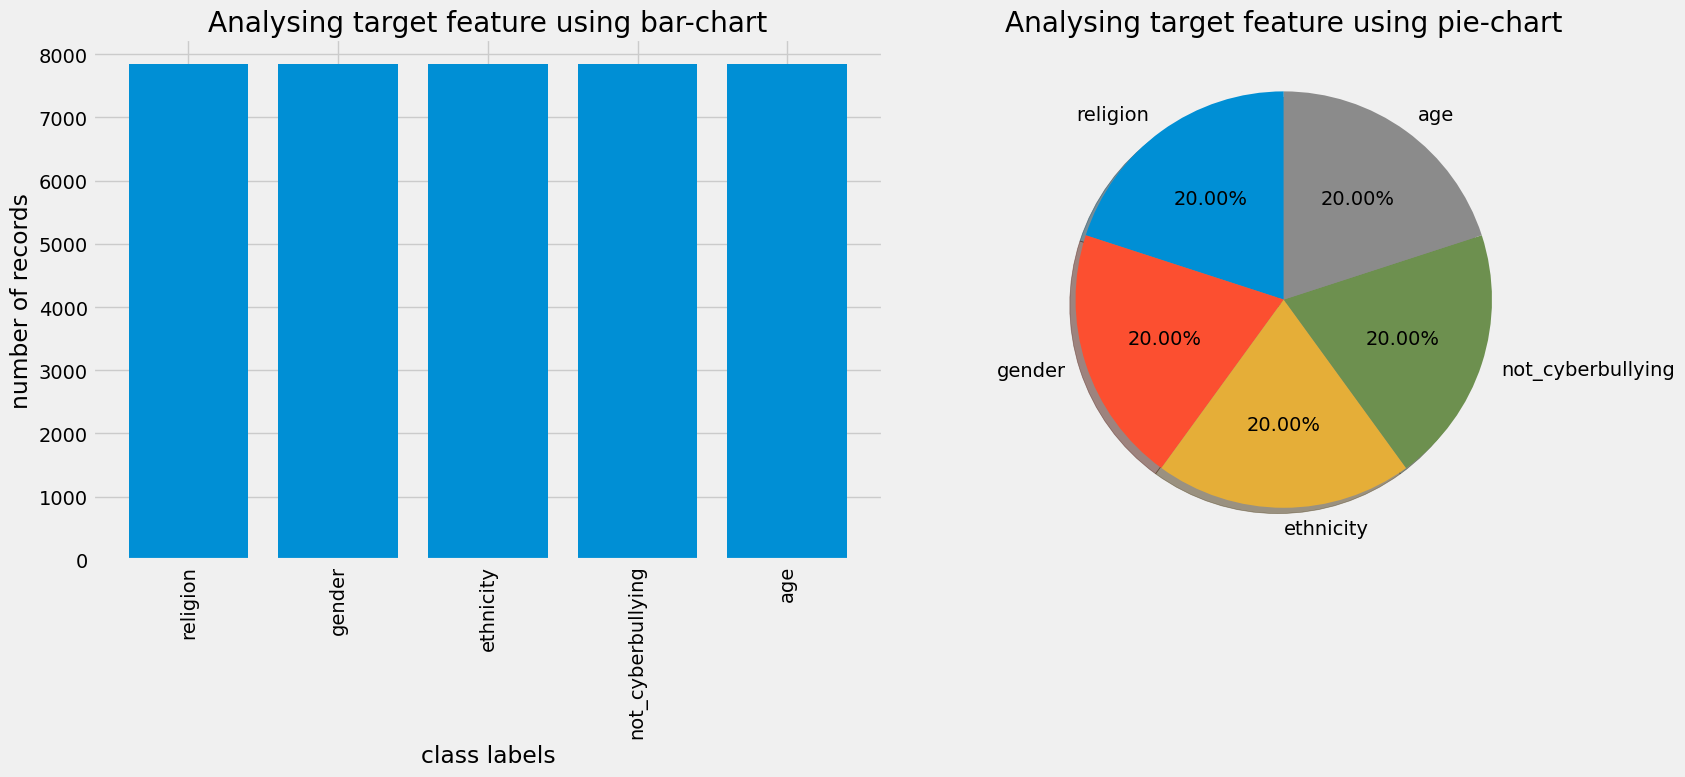

In [25]:
viz_data = dict(data['class'].value_counts())
with plt.style.context(style='fivethirtyeight'):
    fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(18,8))
    axes[0].bar(x=list(viz_data.keys()),
                height=list(viz_data.values()))
    axes[0].set_title(label='Analysing target feature using bar-chart')
    axes[0].set_xlabel(xlabel='class labels')
    axes[0].set_ylabel(ylabel='number of records')
    for tick in axes[0].get_xticklabels():
        tick.set_rotation(90)
    axes[1].pie(x=list(viz_data.values()),
                labels=list(viz_data.keys()),
                autopct='%.2f%%',pctdistance=0.60,
                startangle=90,
                shadow=True)
    axes[1].set_title(label='Analysing target feature using pie-chart')
    fig.tight_layout()
    plt.show()

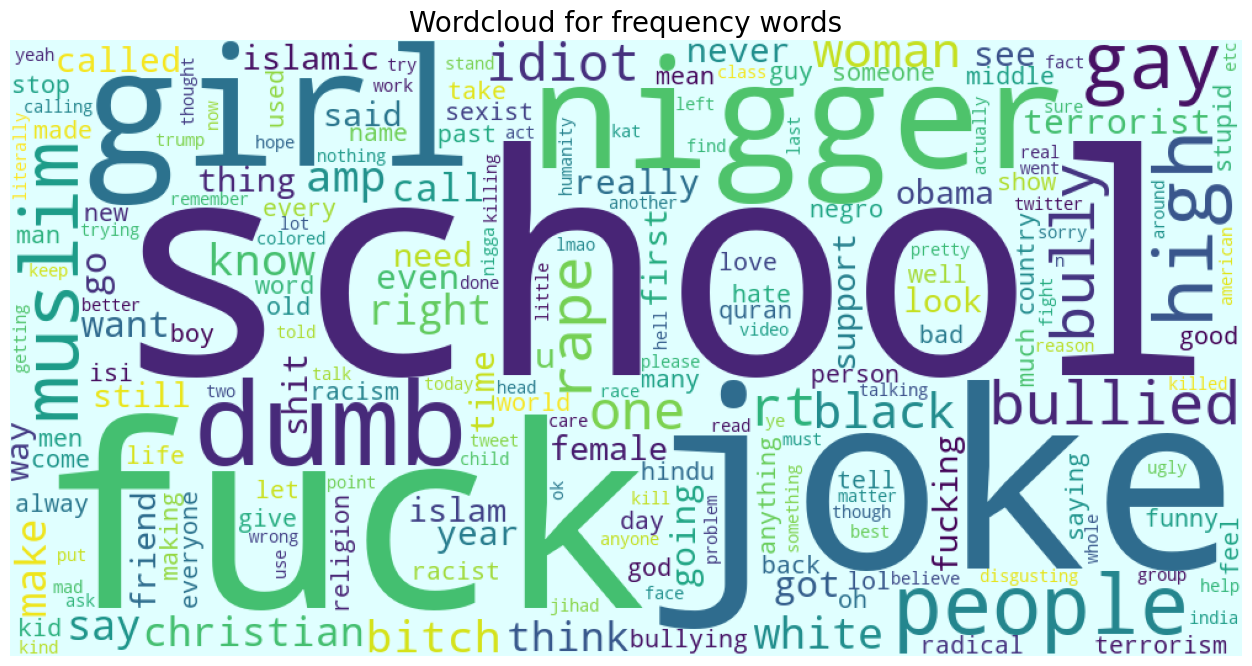

In [27]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
doc_list = ' '.join(question for question in data['cleaned_text'].values)
plt.figure(figsize=(18,8))
wordcloud = WordCloud(
    width=1000,
    background_color='lightcyan',
     height=500,
    stopwords=stopwords,
    collocations=False
).generate(doc_list)
plt.imshow(wordcloud)
plt.axis("off")
plt.title(label='Wordcloud for frequency words',fontsize=20)
plt.show()

---

# Vectorization

In [28]:
tok = Tokenizer()
tok.fit_on_texts(data["cleaned_text"])

In [29]:
num_data = tok.texts_to_sequences(data["cleaned_text"])
print(num_data[:5])

[[18, 43, 69, 1533, 326, 14717, 43, 42, 1533, 21377, 17, 58, 120, 37, 170, 1931, 1627, 120, 265, 51, 7904], [180, 299, 407, 63, 1975, 35, 4032, 525, 27, 7905], [11221, 8, 57, 8, 153, 136, 11222, 7, 9144, 36, 7906, 294, 7, 473, 11223, 1438, 136, 27, 19, 7, 3], [664, 1, 71, 9145, 1358, 14718, 447, 141], [6436, 60, 631, 931, 224, 218, 1, 48, 5094, 208]]


In [30]:
vocab_size=len(tok.word_index)+1
print("Unique tokens size are {}.".format(vocab_size))

Unique tokens size are 31503.


In [31]:
tok.word_index.items()

dict_items([('i', 1), ('school', 2), ('fuck', 3), ('like', 4), ('joke', 5), ('girl', 6), ('dumb', 7), ('nigger', 8), ('people', 9), ('high', 10), ('bullied', 11), ('you', 12), ('gay', 13), ('bully', 14), ('rape', 15), ('rt', 16), ('one', 17), ('idiot', 18), ('as', 19), ('muslim', 20), ('the', 21), ('woman', 22), ('get', 23), ('would', 24), ('black', 25), ('amp', 26), ('bitch', 27), ('know', 28), ('white', 29), ('say', 30), ('right', 31), ('think', 32), ('make', 33), ('it', 34), ('call', 35), ('go', 36), ('muslims', 37), ('got', 38), ('want', 39), ('and', 40), ('time', 41), ('even', 42), ('christian', 43), ('called', 44), ('shit', 45), ('see', 46), ('never', 47), ('really', 48), ('going', 49), ('year', 50), ('still', 51), ('this', 52), ('first', 53), ('terrorist', 54), ('obama', 55), ('thing', 56), ('fucking', 57), ('islamic', 58), ('said', 59), ('if', 60), ('support', 61), ('also', 62), ('female', 63), ('way', 64), ('bullying', 65), ('islam', 66), ('but', 67), ('a', 68), ('need', 69), 

In [32]:
import pickle
with open(file="models/tokens.pkl",mode="wb") as file:
    pickle.dump(obj=tok,file=file)

In [33]:
pad_text = pad_sequences(sequences=num_data,maxlen=40,padding="post",truncating="post")

In [34]:
pad_text[:5]

array([[   18,    43,    69,  1533,   326, 14717,    43,    42,  1533,
        21377,    17,    58,   120,    37,   170,  1931,  1627,   120,
          265,    51,  7904,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  180,   299,   407,    63,  1975,    35,  4032,   525,    27,
         7905,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [11221,     8,    57,     8,   153,   136, 11222,     7,  9144,
           36,  7906,   294,     7,   473, 11223,  1438,   136,    27,
           19,     7,     3,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [  664,     1,    71,  9145,  

In [35]:
class_dict = {}
for idx,label in enumerate(class_labels):
    class_dict[label]=idx
print(class_dict)

{'age': 0, 'ethnicity': 1, 'gender': 2, 'not_cyberbullying': 3, 'religion': 4}


In [36]:
data['class'] = data['class'].map(class_dict)
data.head()

,cleaned_text,class
0,idiot christian need complain america 73 chris...,4
1,anyone else hear female reporter call kayleigh...,2
2,stupide nigger fucking nigger better stupid ho...,1
3,sometimes i hate brisbane tweeting 1hr behind ...,3
4,catching if society judge two pretty i really ...,2


In [37]:
y = data['class'].values
print(y.tolist())

[4, 2, 1, 3, 2, 0, 4, 1, 0, 4, 2, 0, 0, 4, 2, 3, 1, 2, 2, 4, 0, 1, 0, 2, 2, 1, 2, 3, 1, 0, 0, 3, 1, 3, 0, 0, 4, 2, 0, 0, 3, 2, 0, 0, 2, 4, 2, 4, 1, 1, 4, 1, 4, 4, 4, 3, 2, 2, 4, 0, 3, 2, 4, 2, 1, 4, 1, 2, 1, 4, 0, 3, 0, 2, 0, 2, 0, 2, 3, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 2, 4, 2, 1, 0, 2, 3, 3, 3, 3, 2, 1, 4, 3, 2, 1, 2, 4, 2, 4, 1, 3, 3, 4, 2, 1, 2, 3, 4, 0, 1, 3, 3, 2, 1, 4, 0, 0, 3, 1, 3, 4, 0, 3, 1, 1, 0, 3, 3, 3, 2, 3, 4, 4, 4, 2, 1, 2, 1, 1, 1, 3, 4, 0, 0, 4, 1, 0, 1, 1, 1, 3, 3, 3, 1, 3, 3, 0, 2, 0, 0, 2, 0, 2, 0, 0, 3, 4, 0, 4, 4, 1, 0, 0, 3, 0, 1, 0, 4, 2, 3, 1, 3, 4, 0, 4, 3, 2, 4, 3, 2, 3, 0, 0, 4, 2, 2, 1, 4, 3, 0, 2, 0, 4, 2, 0, 2, 2, 3, 4, 0, 3, 1, 3, 2, 1, 4, 2, 4, 1, 2, 2, 0, 1, 0, 3, 2, 2, 0, 2, 1, 4, 1, 4, 3, 3, 0, 4, 4, 4, 0, 1, 3, 0, 0, 4, 2, 3, 0, 0, 3, 1, 2, 0, 3, 1, 2, 1, 0, 3, 3, 3, 1, 2, 1, 3, 2, 2, 3, 2, 2, 1, 3, 3, 2, 3, 3, 3, 0, 2, 0, 3, 3, 1, 3, 3, 2, 1, 4, 4, 0, 0, 0, 1, 2, 2, 1, 2, 3, 0, 1, 2, 0, 0, 4, 1, 0, 1, 1, 4, 1, 0, 2, 1, 3, 0, 2, 0, 2, 0, 0, 2, 1, 